# Multiome analysis focusing of differential accessibility

## Libraries

In [ ]:
import snapatac2 as snap
import scanpy as sc
import scanpy.external as sce
import anndata as ad
import pandas as pd
import numpy as np
import seaborn as sns
import re
import gc
import matplotlib.pyplot as plt
from pybedtools import BedTool
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats
import os
import pickle as pkl

## Data

In [2]:
peaks = pd.read_csv("write/peaks/peak_mats/Merged.peak_mat.csv", index_col=0).transpose()

In [3]:
covar = pd.read_csv("../../sample_info/multiome.fid.age.sex.ethnicity.tsv", sep="\t", names=['FID','SEX','AGE','POP'])

In [10]:
counts = peaks.apply(sum, axis=1)

In [4]:
pattern = re.compile("\(\'(D\d+)\', \'(.+)\', \'([A-Z]+)\'\)")

In [5]:
peaks['FID'] = list(pd.Series(peaks.index).apply(lambda x: pattern.search(x).group(1)))
peaks['ctype'] = list(pd.Series(peaks.index).apply(lambda x: pattern.search(x).group(2)))
peaks['COND'] = list(pd.Series(peaks.index).apply(lambda x: pattern.search(x).group(3)))

In [6]:
peak_covars = peaks[['FID']].merge(covar)
peak_covars.index = peaks.index
peaks[['SEX','AGE','POP']] = peak_covars[['SEX','AGE','POP']]

In [37]:
# reorder categories 
peaks['COND'] = pd.Series(peaks['COND'], dtype="category").cat.reorder_categories(['CTL','LPS'])
peaks['POP'] = pd.Series(peaks['POP'], dtype="category").cat.reorder_categories(['Tikari','Fulani'])

### test CTL monocytes between Tikari and Fulani

In [47]:
from pydeseq2.utils import load_example_data

In [48]:
counts_df = load_example_data(
    modality="raw_counts",
    dataset="synthetic",
    debug=False,
)

metadata = load_example_data(
    modality="metadata",
    dataset="synthetic",
    debug=False,
)

In [65]:
peaks_sub = peaks[(peaks['ctype']=="DNT") & (peaks['COND']=="CTL")]

In [66]:
counts_sub = peaks_sub.drop(['FID','ctype','COND','SEX','AGE','POP'], axis=1)

In [67]:
meta_sub = peaks_sub[['SEX','AGE','POP','COND']]

In [68]:
peaks_to_keep = counts_sub.columns[counts_sub.sum(axis=0) >= 10]

In [69]:
counts_sub = counts_sub[peaks_to_keep]

In [71]:
inference = DefaultInference(n_cpus=8)
dds = DeseqDataSet(
    counts=counts_sub,
    metadata=meta_sub,
    design="~POP",  # compare samples based on the "condition"
    # column ("B" vs "A")
    refit_cooks=True,
    inference=inference,
)

In [72]:
dds.deseq2()

Using None as control genes, passed at DeseqDataSet initialization


Fitting size factors...
/home/derkelly/miniconda3/envs/multiome/lib/python3.11/site-packages/pydeseq2/dds.py:533: UserWarning: Every gene contains at least one zero, cannot compute log geometric means. Switching to iterative mode.
  self.fit_size_factors(
Fitting dispersions...
... done in 7.26 seconds.

Fitting MAP dispersions...
... done in 11.75 seconds.

Fitting dispersions...
... done in 7.14 seconds.

Fitting MAP dispersions...
... done in 13.28 seconds.

Fitting dispersions...
... done in 4.71 seconds.

Fitting MAP dispersions...
... done in 12.85 seconds.

Fitting dispersions...
... done in 4.46 seconds.

Fitting MAP dispersions...
... done in 12.36 seconds.

Fitting dispersions...
... done in 5.18 seconds.

Fitting MAP dispersions...
... done in 12.96 seconds.

Fitting dispersions...
... done in 6.71 seconds.

Fitting MAP dispersions...
... done in 12.46 seconds.

Fitting dispersions...
... done in 9.68 seconds.

Fitting MAP dispersions...
... done in 12.28 seconds.

Fitting d

In [76]:
dds.obsm['design_matrix']

,Intercept,POP[T.Fulani]
"('D0746', 'DNT', 'CTL')",1.0,1
"('D0779', 'DNT', 'CTL')",1.0,1
"('D0787', 'DNT', 'CTL')",1.0,1
"('D0810', 'DNT', 'CTL')",1.0,1
"('D0812', 'DNT', 'CTL')",1.0,1
"('D0814', 'DNT', 'CTL')",1.0,1
"('D0826', 'DNT', 'CTL')",1.0,1
"('D0835', 'DNT', 'CTL')",1.0,1
"('D0840', 'DNT', 'CTL')",1.0,1
"('D0843', 'DNT', 'CTL')",1.0,1


In [77]:
ds = DeseqStats(dds, contrast=np.array([0, 1]), inference=inference)

In [79]:
ds.summary()

Running Wald tests...


Log2 fold change & Wald test p-value, contrast vector: [0 1]
                           baseMean  log2FoldChange     lfcSE      stat  \
chr1:633796-634296        14.191551        5.319254  2.280008  2.332998   
chr1:778495-778995         0.087012        3.650865  1.376705  2.651885   
chr1:904499-904999         0.082921        3.665204  1.846514  1.984931   
chr1:959063-959563         0.104971        3.707454  1.687639  2.196828   
chr1:1013171-1013671       0.053327        4.373288  1.403138  3.116790   
...                             ...             ...       ...       ...   
chrX:154490537-154491037  14.205865        4.766089  2.192118  2.174194   
chrX:154516063-154516563   0.946468        4.210997  1.908453  2.206497   
chrX:154546859-154547359   0.071958        3.605437  1.274741  2.828369   
chrX:154762499-154762999   0.110667        3.128523  1.538355  2.033681   
chrX:155026678-155027178  14.156843        5.453428  2.092211  2.606539   

                            pvalue    

... done in 1.73 seconds.



Running Wald tests...
... done in 21.03 seconds.



Log2 fold change & Wald test p-value, contrast vector: [0 1]
                           baseMean  log2FoldChange     lfcSE      stat  \
chr1:633796-634296        14.191551        5.319254  2.280008  2.289138   
chr1:778495-778995         0.087012        3.650865  1.376705  2.579248   
chr1:904499-904999         0.082921        3.665204  1.846514  1.930775   
chr1:959063-959563         0.104971        3.707454  1.687639  2.137574   
chr1:1013171-1013671       0.053327        4.373288  1.403138  3.045521   
...                             ...             ...       ...       ...   
chrX:154490537-154491037  14.205865        4.766089  2.192118  2.128576   
chrX:154516063-154516563   0.946468        4.210997  1.908453  2.154099   
chrX:154546859-154547359   0.071958        3.605437  1.274741  2.749922   
chrX:154762499-154762999   0.110667        3.128523  1.538355  1.968677   
chrX:155026678-155027178  14.156843        5.453428  2.092211  2.558742   

                            pvalue    

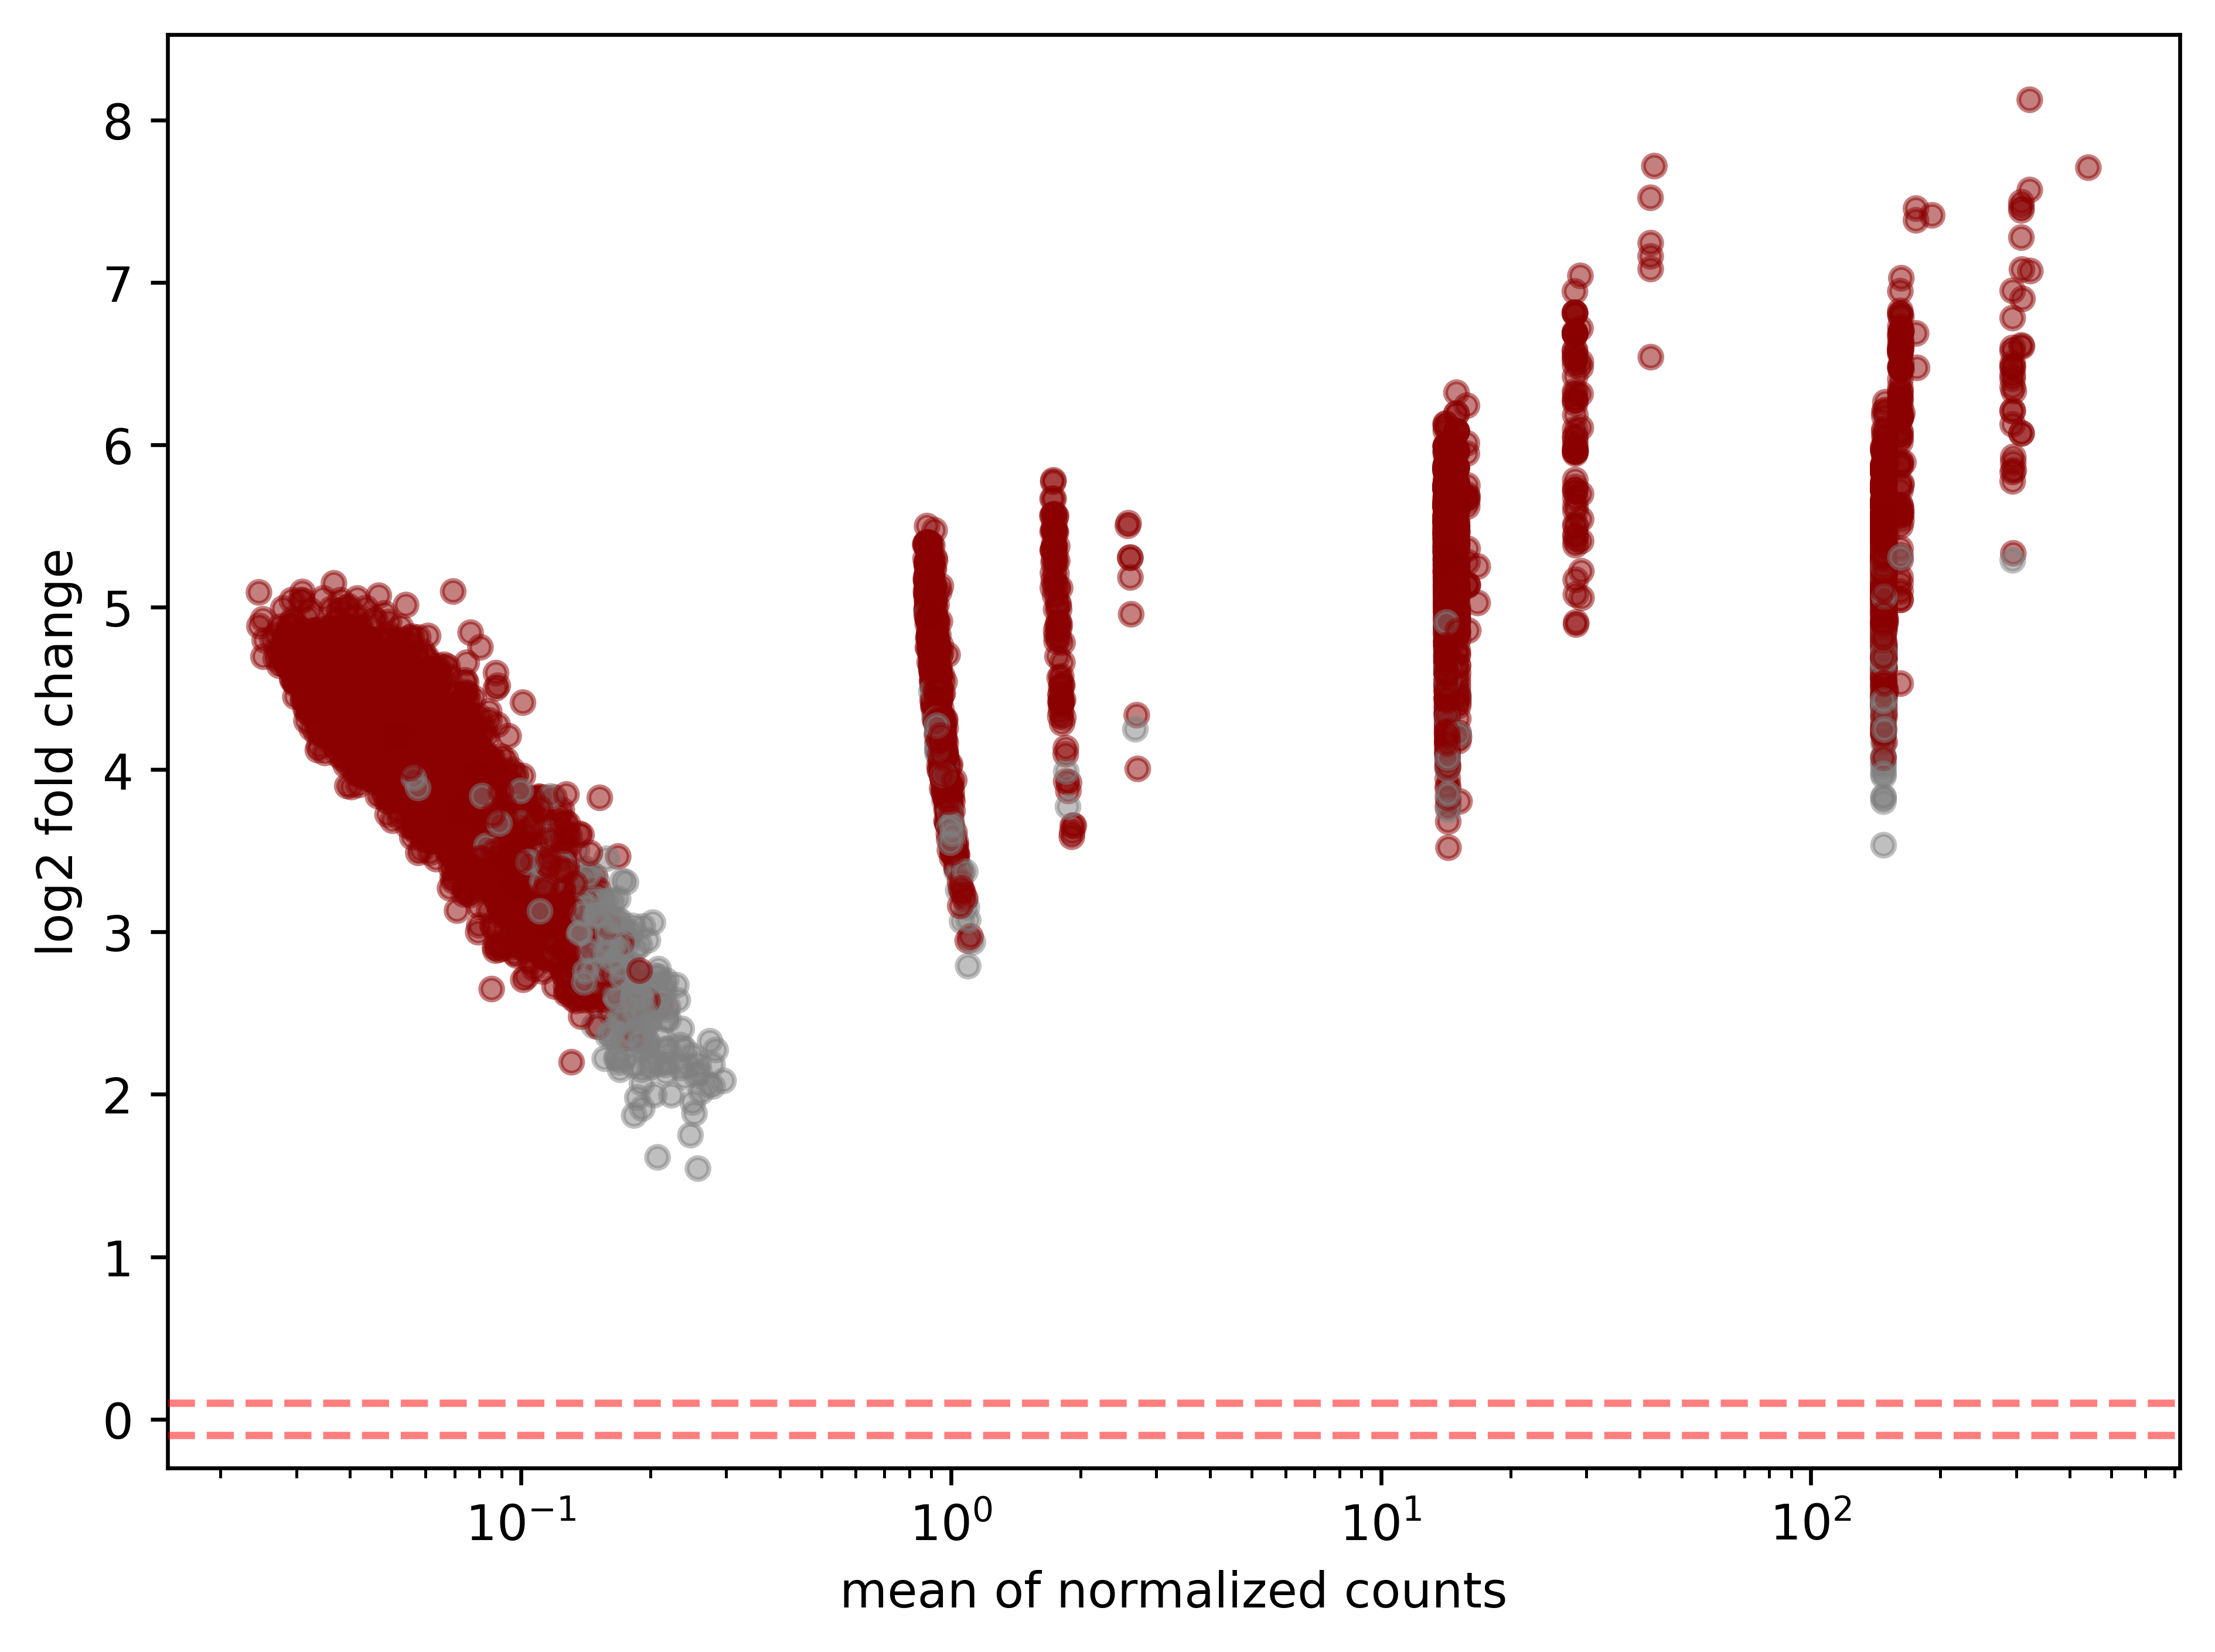

In [82]:
ds.summary(lfc_null=0.1, alt_hypothesis="greaterAbs")
ds.plot_MA(s=20)

In [78]:
dds.fit_size_factors()

Fitting size factors...


Using None as control genes, passed at DeseqDataSet initialization


... done in 0.86 seconds.



In [82]:
dds.fit_genewise_dispersions()

Fitting dispersions...
... done in 381.97 seconds.



In [88]:
dds.fit_dispersion_trend()

Fitting dispersion trend curve...
/home/derkelly/miniconda3/envs/multiome/lib/python3.11/site-packages/pydeseq2/dds.py:805: UserWarning: The dispersion trend curve fitting did not converge. Switching to a mean-based dispersion trend.
  self._fit_parametric_dispersion_trend(vst)
... done in 8.69 seconds.



In [89]:
dds.fit_dispersion_prior()

In [90]:
dds.fit_MAP_dispersions()

Fitting MAP dispersions...
... done in 1109.94 seconds.



In [91]:
dds.fit_LFC()

Fitting LFCs...
... done in 469.90 seconds.



In [97]:
dds.calculate_cooks()

Calculating cook's distance...
... done in 3.15 seconds.



In [99]:
dds.refit_cooks

True

In [100]:
if dds.refit_cooks:
    # Replace outlier counts
    dds.refit()

Replacing 11 outlier genes.

Fitting dispersions...
... done in 0.02 seconds.

Fitting MAP dispersions...
... done in 0.05 seconds.

Fitting LFCs...
... done in 0.04 seconds.



In [105]:
with open("M_CTL_test.pkl", "wb") as f:
    pkl.dump(dds, f)

In [11]:
with open("M_CTL_test.pkl", 'rb') as file:
    dds = pkl.load(file)

In [12]:
ds = DeseqStats(
    dds,
    contrast=np.array([0, 1]),
    alpha=0.05,
    cooks_filter=True,
    independent_filter=True,
)

In [13]:
ds.run_wald_test()

Running Wald tests...
... done in 238.08 seconds.



In [27]:
if ds.cooks_filter:
    ds._cooks_filtering()
ds.p_values

chr1:9868-10368           0.719654
chr1:17231-17731          0.133264
chr1:28802-29302          0.616694
chr1:91048-91548          0.479686
chr1:103915-104415        0.956448
                            ...   
chrY:21246753-21247253    0.716827
chrY:21248532-21249032    0.817727
chrY:21249334-21249834    0.792291
chrY:21256764-21257264    0.438986
chrY:21260208-21260708    0.674081
Length: 270630, dtype: float64

In [42]:
ds.results_df.to_csv("foo.csv")

In [28]:
da = ds.results_df
da['nltpvalue'] = -np.log10(da['pvalue'])

In [30]:
if ds.independent_filter:
    ds._independent_filtering()
else:
    ds._p_value_adjustment()

ds.padj

chr1:9868-10368           0.869276
chr1:17231-17731               NaN
chr1:28802-29302               NaN
chr1:91048-91548               NaN
chr1:103915-104415             NaN
                            ...   
chrY:21246753-21247253         NaN
chrY:21248532-21249032         NaN
chrY:21249334-21249834         NaN
chrY:21256764-21257264         NaN
chrY:21260208-21260708         NaN
Name: 30, Length: 270630, dtype: float64

<Axes: xlabel='log2FoldChange', ylabel='nltpvalue'>

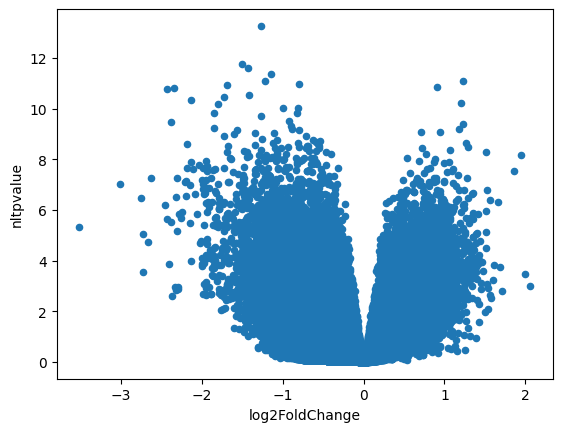

In [29]:
da.plot.scatter(x='log2FoldChange', y='nltpvalue')

In [34]:
ds.results_df

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,nltpvalue
chr1:9868-10368,7.291430,-0.041757,0.116341,-0.358921,0.719654,0.869276,0.142876
chr1:17231-17731,0.270031,-0.798468,0.531832,-1.501353,0.133264,NaN,0.875286
chr1:28802-29302,0.362608,0.229920,0.459342,0.500541,0.616694,NaN,0.209930
chr1:91048-91548,0.965659,0.241210,0.341266,0.706808,0.479686,NaN,0.319043
chr1:103915-104415,0.502621,-0.028268,0.517633,-0.054611,0.956448,NaN,0.019338
...,...,...,...,...,...,...,...
chrY:21246753-21247253,0.167423,-0.443815,1.223636,-0.362702,0.716827,NaN,0.144585
chrY:21248532-21249032,0.093213,-0.289612,1.256617,-0.230470,0.817727,NaN,0.087392
chrY:21249334-21249834,0.199112,-0.234355,0.889944,-0.263337,0.792291,NaN,0.101116
chrY:21256764-21257264,0.334746,0.914340,1.181461,0.773906,0.438986,NaN,0.357549


In [22]:
ds.results_df.sort_values('pvalue').head(20)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,nltpvalue
chr15:52512815-52513315,4.348476,-1.263198,0.167920,-7.522607,5.369484e-14,6.079115e-09,13.270067
chr20:44660510-44661010,11.525439,-1.496979,0.212234,-7.053437,1.745516e-12,9.339057e-08,11.758076
chr2:191202129-191202629,6.461197,-1.429806,0.204120,-7.004728,2.474665e-12,9.339057e-08,11.606484
chr6:11824948-11825448,9.009601,-1.150270,0.166022,-6.928428,4.255430e-12,1.204457e-07,11.371057
chr11:116332899-116333399,7.473099,1.234058,0.180457,6.838500,8.002643e-12,1.575705e-07,11.096767
chr16:11212437-11212937,10.403365,-1.218074,0.178279,-6.832399,8.350613e-12,1.575705e-07,11.078282
chr3:129695236-129695736,7.886113,-0.804010,0.118338,-6.794197,1.089178e-11,1.627472e-07,10.962901
chr1:206796989-206797489,6.294808,-1.690365,0.249083,-6.786358,1.149994e-11,1.627472e-07,10.939304
chr20:16390920-16391420,7.175949,0.908252,0.134307,6.762515,1.356163e-11,1.652015e-07,10.867688
chr2:112977496-112977996,3.300618,-2.345330,0.347756,-6.744179,1.538952e-11,1.652015e-07,10.812775


## Analyze

In [32]:
results = pd.read_csv("output/deseq2/M.Tikari_Fulani.CTL.csv", index_col=0)

In [33]:
results['nltpvalue'] = -np.log10(results['pvalue'])

In [34]:
results.sort_values('pvalue').head(10)

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,nltpvalue
chr15:52512815-52513315,4.348476,1.263315,0.167581,7.538534,4.752837e-14,5.767187e-09,13.323047
chr20:44660510-44661010,11.525439,1.496995,0.212034,7.060158,1.663131e-12,9.363536e-08,11.779074
chr2:191202129-191202629,6.461197,1.429906,0.203863,7.014060,2.314995e-12,9.363536e-08,11.635450
chr6:11824948-11825448,9.009601,1.150308,0.165828,6.936731,4.012760e-12,1.217291e-07,11.396557
chr11:116332899-116333399,7.473099,-1.234037,0.180221,-6.847347,7.523196e-12,1.599178e-07,11.123598
chr16:11212437-11212937,10.403365,1.218154,0.178087,6.840215,7.907458e-12,1.599178e-07,11.101963
chr3:129695236-129695736,7.886113,0.804326,0.118097,6.810738,9.709915e-12,1.659398e-07,11.012785
chr1:206796989-206797489,6.294808,1.690432,0.248829,6.793556,1.094030e-11,1.659398e-07,10.960971
chr20:16390920-16391420,7.175949,-0.908235,0.134062,-6.774742,1.246286e-11,1.680298e-07,10.904382
chr2:112977496-112977996,3.300618,2.345264,0.347364,6.751595,1.462288e-11,1.682797e-07,10.834967


<Axes: xlabel='log2FoldChange', ylabel='nltpvalue'>

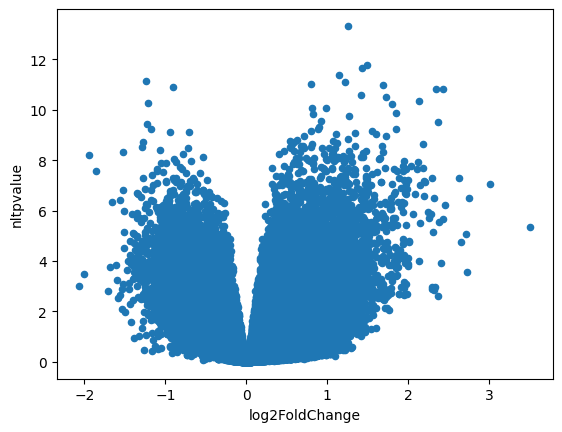

In [35]:
results.plot.scatter(x='log2FoldChange', y='nltpvalue')

In [46]:
results[(results['padj'] < 0.05) & (results['log2FoldChange'] > 0)].to_csv("M.Tikari_Fulani.CTL.FDR05.F.csv")

### Effect size differences between populations

In [13]:
rtf = pd.read_csv("output/deseq2/M.Tikari_Fulani.CTL.csv", index_col=0)
rt = pd.read_csv("output/deseq2/M.Tikari.CTL_LPS.csv", index_col=0)
rf = pd.read_csv("output/deseq2/M.Fulani.CTL_LPS.csv", index_col=0)

In [11]:
rtrf = rt[['log2FoldChange']].merge(rf[['log2FoldChange']], left_index=True, right_index=True)

<Axes: xlabel='log2FoldChange_x', ylabel='log2FoldChange_y'>

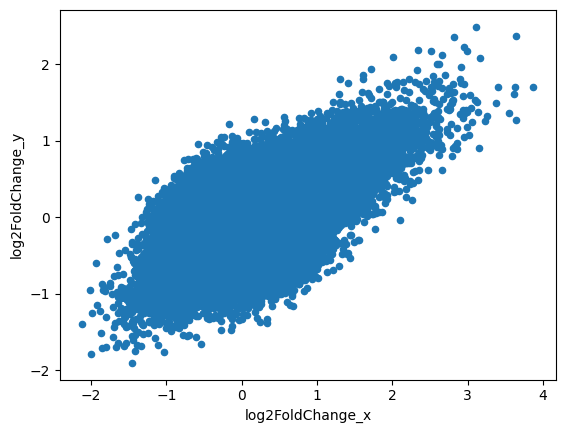

In [12]:
rtrf.plot.scatter(x='log2FoldChange_x', y='log2FoldChange_y')

In [23]:
rt.sort_values('log2FoldChange').head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
chr7:65965983-65966483,1.125987,-2.114261,0.338664,-6.242940,4.294213e-10,1.894733e-08
chr8:20047305-20047805,1.446969,-2.008187,0.292140,-6.874049,6.240473e-12,3.807963e-10
chr8:81496724-81497224,1.313014,-1.996055,0.318959,-6.258021,3.898943e-10,1.734454e-08
chr15:52714955-52715455,3.286524,-1.989955,0.215530,-9.232850,2.635255e-20,4.666447e-18
chr12:63409882-63410382,1.009508,-1.931688,0.320338,-6.030152,1.638056e-09,6.470077e-08


In [15]:
rtfrt = rtf[['log2FoldChange']].merge(rt[['log2FoldChange']], left_index=True, right_index=True)
rtfrf = rtf[['log2FoldChange']].merge(rf[['log2FoldChange']], left_index=True, right_index=True)

<Axes: xlabel='log2FoldChange_x', ylabel='log2FoldChange_y'>

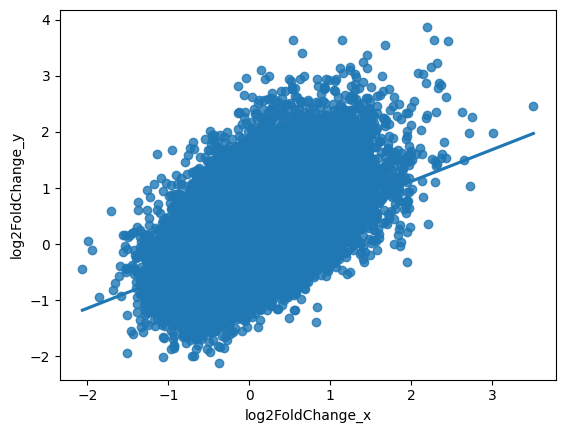

In [21]:
sns.regplot(rtfrt, x='log2FoldChange_x', y='log2FoldChange_y')

<Axes: xlabel='log2FoldChange_x', ylabel='log2FoldChange_y'>

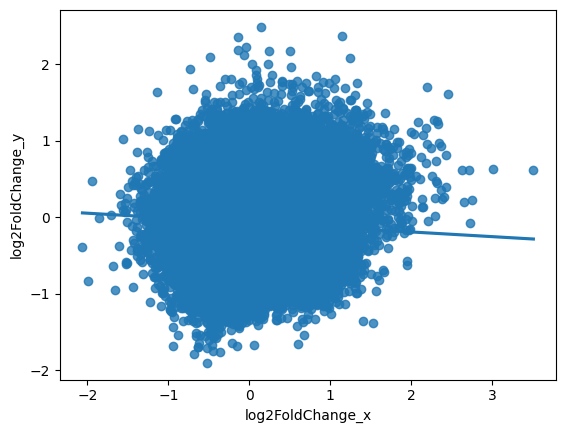

In [22]:
sns.regplot(rtfrf, x='log2FoldChange_x', y='log2FoldChange_y')

In [24]:
rf.sort_values('log2FoldChange', ascending=False).head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
chr15:38631046-38631546,2.663003,2.489449,0.255097,9.758815,1.691202e-22,3.491376e-18
chr4:184891767-184892267,2.903146,2.365080,0.263772,8.966391,3.063882e-19,2.053210e-15
chr11:35859194-35859694,4.374895,2.356227,0.252280,9.339744,9.656745e-21,1.088990e-16
chr5:159398882-159399382,1.295576,2.222769,0.410888,5.409675,6.313918e-08,1.232157e-05
chr5:180858547-180859047,1.819484,2.179849,0.313877,6.944913,3.786936e-12,3.107451e-09


## Format data for Homer

I am going to get all DA regions that are 1) FDR < 0.05, and 2) either (+) LFC or (-), separating for analysis. I will also output a background set of all analyzed regions.

In [104]:
results = pd.read_csv("output/deseq2/M.Tikari_Fulani.CTL.csv", index_col=0)

In [105]:
results['nltpvalue'] = -np.log10(results['pvalue'])

<Axes: xlabel='log2FoldChange', ylabel='nltpvalue'>

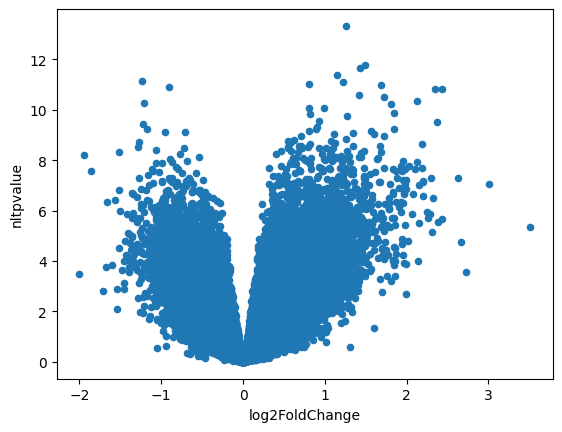

In [106]:
results[~results['padj'].isna()].plot.scatter(x='log2FoldChange', y='nltpvalue')

<Axes: ylabel='Frequency'>

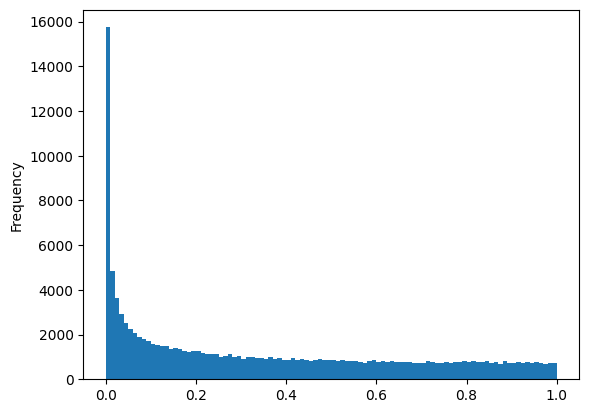

In [107]:
results[~results['padj'].isna()]['pvalue'].plot.hist(bins=100)

<Axes: ylabel='Frequency'>

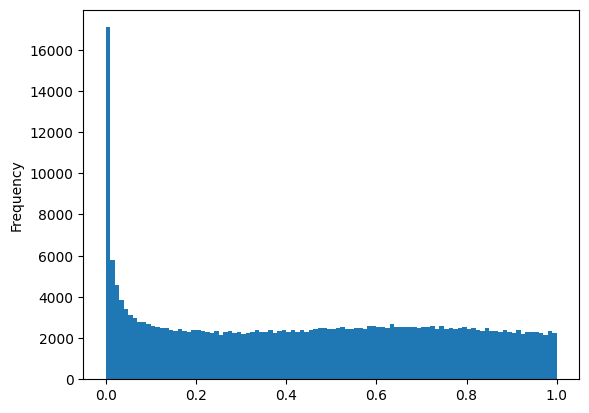

In [108]:
results['pvalue'].plot.hist(bins=100)

In [95]:
pattern = re.compile("(chr.+):(\d+)-(\d+)")

In [ ]:
chrs = list(pd.Series(results[results['padj'] < 0.05].index).apply(lambda x: pattern.search(x).group(1)))

The p-values only appear well calibrated when removing all sites where padj is nan. I suppose I can simply ignore nan and only look for padj < 0.05.

In [5]:
ctype = "CD4-T"
pop="Fulani"

res = pd.read_csv("output/deseq2/{}.{}.CTL_LPS.csv".format(ctype,pop), index_col=0)
res = res[~res['padj'].isna()] # remove NaN

bed_bg = pd.Series(res.index).apply(lambda x: pattern.search(x))        
bed_sig = bed_bg[res['padj'] < 0.05]

pd.DataFrame({'chr': bed_bg.apply(lambda x: x.group(1)),
              'start': bed_bg.apply(lambda x: x.group(2)),
              'end': bed_bg.apply(lambda x: x.group(3))}) \
    .to_csv("regions/{}.{}.CTL_LPS.bg.csv".format(ctype,pop), index=False, header=False, sep="\t")

pd.DataFrame({'chr': bed_bg.apply(lambda x: x.group(1)),
              'start': bed_bg.apply(lambda x: x.group(2)),
              'end': bed_bg.apply(lambda x: x.group(3))}) \
    .to_csv("regions/{}.{}.CTL_LPS.bg.csv".format(ctype,pop), index=False, header=False, sep="\t")

pd.DataFrame({'chr': bed_bg.apply(lambda x: x.group(1)),
              'start': bed_bg.apply(lambda x: x.group(2)),
              'end': bed_bg.apply(lambda x: x.group(3))}) \
    .to_csv("regions/{}.{}.CTL_LPS.bg.csv".format(ctype,pop), index=False, header=False, sep="\t")

IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

In [117]:
bed_df

,chr,start,end
0,chr1,991194,991694
1,chr1,1009135,1009635
2,chr1,1013171,1013671
3,chr1,1019381,1019881
4,chr1,1026480,1026980
...,...,...,...
5058,chrX,154326912,154327412
5059,chrX,154827514,154828014
5060,chrX,155197928,155198428
5061,chrX,155577640,155578140


In [2]:
def write_bed(m, f):
    
    pd.DataFrame({'chr': m.apply(lambda x: x.group(1)),
                  'start': m.apply(lambda x: x.group(2)),
                  'end': m.apply(lambda x: x.group(3))}).to_csv(f, index=False, header=False, sep="\t")


def write_beds(res, f_pref):

    res_sig = res[res['padj'] < 0.05]

    pattern = re.compile("(chr.+):(\d+)-(\d+)")
    
    bed_bg = pd.Series(res.index).apply(lambda x: pattern.search(x))        
    bed_sig = bed_bg[list(res['padj'] < 0.05)]
    bed_up = bed_sig[list(res_sig['log2FoldChange'] > 0)]
    bed_down = bed_sig[list(res_sig['log2FoldChange'] < 0)]
    
    write_bed(bed_bg, "{}.bg.bed".format(f_pref))
    write_bed(bed_up, "{}.up.bed".format(f_pref))
    write_bed(bed_down, "{}.down.bed".format(f_pref))

In [3]:
ctypes = ["CD4-T","CD8-T"]
# ctypes = ["B","DNT","gdT","M","MAIT","NK","Progenitor"] # skip CD4-T and CD8-T for now
for ctype in ctypes:
    print(ctype)
    for pop in ["Tikari","Fulani"]:
        print(pop)

        res = pd.read_csv("output/deseq2/{}.{}.CTL_LPS.csv".format(ctype,pop), index_col=0)
        res = res[~res['padj'].isna()] # remove NaN
        
        write_beds(res, "homer/regions/{}.{}.CTL_LPS".format(ctype,pop))
        
    for cond in ["CTL","LPS"]:
        print(cond)
        
        res = pd.read_csv("output/deseq2/{}.Tikari_Fulani.{}.csv".format(ctype,cond), index_col=0)
        res = res[~res['padj'].isna()] # remove NaN

        write_beds(res, "homer/regions/{}.Tikari_Fulani.{}".format(ctype,cond))

CD4-T
Tikari
Fulani
CTL
LPS
CD8-T
Tikari
Fulani
CTL
LPS


## Attic

In [10]:
counts = peaks.apply(sum, axis=1)

In [12]:
np.sort(counts)

array([2.1400000e+02, 2.5500000e+02, 3.1600000e+02, ..., 3.2384687e+07,
       3.4415648e+07, 4.7913595e+07])

In [3]:
lib_cond = pd.read_csv("misc/lib.id.cond.clean.tsv", sep="\t")

In [10]:
t_m_idx = np.unique(["('{}', 'M', 'CTL')".format(i) for i in np.unique(lib_cond[lib_cond['Ethnicity']=="Tikari"]['FID'])])

In [15]:
lib_cond[lib_cond['FID']=="D1383"]

,BATCH,LIBRARY,FID,COND,LID,TID,SEX,AGE,POP,Ethnicity
352,EBT21,MRA13,D1383,CTL,CATK325,NWD302076,F,53.0,TIKARI,Tikari
353,EBT21,MRA14,D1383,CTL,CATK325,NWD302076,F,53.0,TIKARI,Tikari
354,EBT21,MRA15,D1383,LPS,CATK325,NWD302076,F,53.0,TIKARI,Tikari
355,EBT21,MRA16,D1383,LPS,CATK325,NWD302076,F,53.0,TIKARI,Tikari


In [11]:
t_m_idx = np.unique(["('{}', 'M', 'CTL')".format(i) for i in np.unique(lib_cond[lib_cond['Ethnicity']=="Tikari"]['FID'])])

In [ ]:
peaks.loc[t_m_idx,:]

## Test

In [12]:
rna_ctl = sc.read_h5ad("write/MR_ctl_raw.umap.clean.h5ad")
rna_lps = sc.read_h5ad("write/MR_lps_raw.umap.clean.h5ad")

In [13]:
rna = sc.concat([rna_ctl, rna_lps])

In [36]:
import seaborn as sns

<Axes: xlabel='Cluster_names', ylabel='FID'>

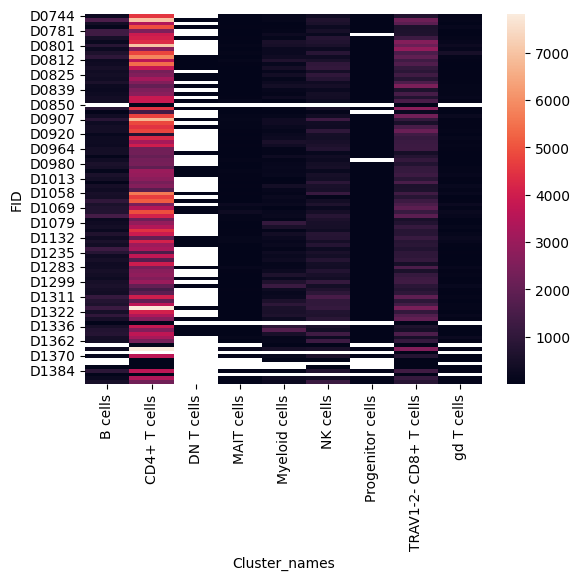

In [39]:
sns.heatmap(rna.obs[['FID','Cluster_names']].value_counts().reset_index().pivot(index="FID", columns="Cluster_names", values="count"))

(array([ 8.,  1.,  7., 20., 35., 12., 11.,  2.,  2.,  2.]),
 array([1.00000e+00, 1.31380e+03, 2.62660e+03, 3.93940e+03, 5.25220e+03,
        6.56500e+03, 7.87780e+03, 9.19060e+03, 1.05034e+04, 1.18162e+04,
        1.31290e+04]),
 <BarContainer object of 10 artists>)

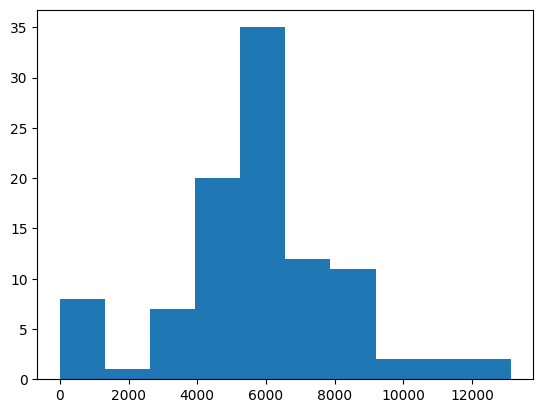

In [43]:
plt.hist(rna.obs['TID'].value_counts())

In [23]:
lib_cond[lib_cond['FID']=="D1333"]

,BATCH,LIBRARY,FID,COND,LID,TID,SEX,AGE,POP,Ethnicity
232,EBT24,MRA37,D1333,CTL,CATK278,NWD795594,F,28.0,TIKARI,Tikari
233,EBT24,MRA38,D1333,CTL,CATK278,NWD795594,F,28.0,TIKARI,Tikari
234,EBT24,MRA39,D1333,LPS,CATK278,NWD795594,F,28.0,TIKARI,Tikari
235,EBT24,MRA40,D1333,LPS,CATK278,NWD795594,F,28.0,TIKARI,Tikari


In [4]:
atac = snap.read("write/anndatas/anndatas/MRA{}.h5ad".format(13))

peak_mat = snap.pp.make_peak_matrix(atac, peak_file = "write/peaks/split/peaks_ALL_summits.500bp.filt.merge.max.bed")

/home/derkelly/miniconda3/envs/multiome/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [5]:
peak_mat

AnnData object with n_obs × n_vars = 14463 × 270630
    obs: 'n_fragment', 'frac_dup', 'frac_mito'

In [6]:
rna

AnnData object with n_obs × n_vars = 569956 × 36601
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'donor_id', 'TID', 'FID', 'BATCH', 'COND', 'SEX', 'AGE', 'Ethnicity', 'leiden', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'FCluster_names', 'Cluster_names', 'SCluster_names', 'lineage', 'lineage_match'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    layers: 'raw_counts'